In [1]:
import numpy as np
import torch
import torchvision
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
pitches_df = pd.read_csv("data.csv")

In [3]:
pitches_df.head()

,PITCH_TYPE,PITCH_NAME,PLAYER_NAME,BATTER_ID,PITCHER_ID,BAT_SIDE,THROW_SIDE,GAME_PK,GAME_YEAR,GAME_DATE,...,HOME_SCORE,AWAY_SCORE,BAT_SCORE,FLD_SCORE,POST_AWAY_SCORE,POST_HOME_SCORE,POST_BAT_SCORE,POST_FLD_SCORE,DELTA_HOME_WIN_EXP,DELTA_RUN_EXP
0,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.038
1,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,-0.049
2,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.052
3,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.113
4,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,-0.077


In [4]:
# function for cleaning datasets of unnecessary columns for analysis
def clean_df(df: pd.DataFrame) -> pd.DataFrame:    
    temp_df = df
    # map pitch type to new categories:
    # FB = Fastball
    # BB = Breaking Ball
    # OS = Off Speed
    temp_df.loc[temp_df["PITCH_TYPE"].isin(["FC", "FF", "SI", "FS"]), "PITCH_TYPE"] = "FB"
    temp_df.loc[temp_df["PITCH_TYPE"].isin(["CU", "KC", "SL", "ST", "SC", "SV"]), "PITCH_TYPE"] = "BB"
    temp_df.loc[temp_df["PITCH_TYPE"].isin(["CH", "CS", "EP", "KN", "FO"]), "PITCH_TYPE"] = "OS"
    
    return temp_df

In [5]:
pitches_df = clean_df(pitches_df)
pitches_df.columns


Index(['PITCH_TYPE', 'PITCH_NAME', 'PLAYER_NAME', 'BATTER_ID', 'PITCHER_ID',
       'BAT_SIDE', 'THROW_SIDE', 'GAME_PK', 'GAME_YEAR', 'GAME_DATE',
       'HOME_TEAM', 'AWAY_TEAM', 'INNING', 'INNING_TOPBOT', 'AT_BAT_NUMBER',
       'PITCH_NUMBER', 'OUTS_WHEN_UP', 'BALLS', 'STRIKES', 'ON_1B', 'ON_2B',
       'ON_3B', 'IF_FIELDING_ALIGNMENT', 'OF_FIELDING_ALIGNMENT', 'EVENTS',
       'DESCRIPTION', 'TYPE', 'ZONE', 'PLATE_X', 'PLATE_Z', 'SZ_TOP', 'SZ_BOT',
       'BB_TYPE', 'HIT_LOCATION', 'HC_X', 'HC_Y', 'HIT_DISTANCE_SC',
       'LAUNCH_SPEED', 'LAUNCH_ANGLE', 'ESTIMATED_BA_USING_SPEEDANGLE',
       'ESTIMATED_WOBA_USING_SPEEDANGLE', 'WOBA_VALUE', 'WOBA_DENOM',
       'BABIP_VALUE', 'ISO_VALUE', 'LAUNCH_SPEED_ANGLE', 'HOME_SCORE',
       'AWAY_SCORE', 'BAT_SCORE', 'FLD_SCORE', 'POST_AWAY_SCORE',
       'POST_HOME_SCORE', 'POST_BAT_SCORE', 'POST_FLD_SCORE',
       'DELTA_HOME_WIN_EXP', 'DELTA_RUN_EXP'],
      dtype='object')

In [6]:
# create a feature set for each batter, historical batting data and league wide pitching statistics
def create_feature_set(df: pd.DataFrame) -> pd.DataFrame:
    feature_df = pd.read_csv("predictions.csv")
    feature_df = feature_df.iloc[:, :2]

    # calculate number of pitches each batter faces
    feature_df['pitches'] = df.groupby("BATTER_ID").size().reset_index(name="pitches")['pitches']
    
    # calculate players plate appearances
    temp_df = df.groupby(["BATTER_ID", "GAME_PK"])["AT_BAT_NUMBER"].nunique().reset_index(name='plate_appearances')
    feature_df['plate_appearances'] = temp_df.groupby(["BATTER_ID"])['plate_appearances'].sum().reset_index(name='plate_appearances')['plate_appearances']

    # calculate players hits
    feature_df['hits'] = df.groupby("BATTER_ID")["EVENTS"].apply(lambda x: (x.isin(["single", "double", "triple", "home_run"])).sum()).reset_index(drop=True)

    # calculate players walks
    feature_df['walks'] = df.groupby("BATTER_ID")["EVENTS"].apply(lambda x: (x == "walk").sum()).reset_index(drop=True)

    # calculate players sacrifices (sac-flies and sac-bunts)
    feature_df['sacs'] = df.groupby("BATTER_ID")["EVENTS"].apply(lambda x: ((x == "sac_bunt") | (x == "sac_fly")).sum()).reset_index(drop=True)

    # hit by pitch per batter
    feature_df['hbp'] = df.groupby("BATTER_ID")["EVENTS"].apply(lambda x: (x == "hit_by_pitch").sum()).reset_index(drop=True)

    # calculate the number of players at bats
    feature_df['at_bats'] = feature_df['plate_appearances'] - feature_df['walks'] - feature_df['sacs'] - feature_df['hbp']

    # players batting average
    feature_df['avg'] = feature_df['hits'] / feature_df['at_bats']

    # on base percentage for each player
    feature_df['obp'] = (feature_df["hits"] + feature_df['walks'] + feature_df['hbp']) / feature_df['plate_appearances']

    # number of each pitch type each batter faces
    feature_df['num_fb'] = df.groupby("BATTER_ID")["PITCH_TYPE"].apply(lambda x: (x == "FB").sum()).reset_index(drop=True)
    feature_df['num_bb'] = df.groupby("BATTER_ID")["PITCH_TYPE"].apply(lambda x: (x == "BB").sum()).reset_index(drop=True)
    feature_df['num_os'] = df.groupby("BATTER_ID")["PITCH_TYPE"].apply(lambda x: (x == "OS").sum()).reset_index(drop=True)

    # proportion of pitch type
    feature_df['prop_fb'] = feature_df['num_fb'] / feature_df['pitches']
    feature_df['prop_bb'] = feature_df['num_bb'] / feature_df['pitches']
    feature_df['prop_os'] = feature_df['num_os'] / feature_df['pitches']

    # whiff on pitch type
    feature_df['whiff_fb'] = df.groupby("BATTER_ID").apply(lambda x: (((x["DESCRIPTION"] == "swinging_strike") | (x["DESCRIPTION"] == "swinging_strike_blocked")) & (x["PITCH_TYPE"] == "FB")).sum()).reset_index(drop=True) / feature_df['num_fb']
    feature_df['whiff_bb'] = df.groupby("BATTER_ID").apply(lambda x: (((x["DESCRIPTION"] == "swinging_strike") | (x["DESCRIPTION"] == "swinging_strike_blocked")) & (x["PITCH_TYPE"] == "BB")).sum()).reset_index(drop=True) / feature_df['num_bb']
    feature_df['whiff_os'] = df.groupby("BATTER_ID").apply(lambda x: (((x["DESCRIPTION"] == "swinging_strike") | (x["DESCRIPTION"] == "swinging_strike_blocked")) & (x["PITCH_TYPE"] == "OS")).sum()).reset_index(drop=True) / feature_df['num_os']

    # chase rate (proportion of swings that are at pitches out of the zone)
    feature_df['chase_rate'] = df.groupby("BATTER_ID").apply(lambda x: (
        ((x["DESCRIPTION"].isin(["foul", "foul_bunt", "foul_tip", "hit_into_play", "swinging_strike_blocked", "swinging_strike"])) &
        (x["ZONE"] > 9)).sum() / (x["ZONE"] > 9).sum()
    )).reset_index(drop=True)

    # chase rate on fastball
    feature_df['fb_chase_rate'] = df.groupby("BATTER_ID").apply(lambda x: (
        ((x["DESCRIPTION"].isin(["foul", "foul_bunt", "foul_tip", "hit_into_play", "swinging_strike_blocked", "swinging_strike"])) &
        (x["ZONE"] > 9) & (x["PITCH_TYPE"] == "FB")).sum() / ((x["ZONE"] > 9) & (x["PITCH_TYPE"] == "FB")).sum()
    )).reset_index(drop=True)

    # chase rate on breaking ball
    feature_df['bb_chase_rate'] = df.groupby("BATTER_ID").apply(lambda x: (
        ((x["DESCRIPTION"].isin(["foul", "foul_bunt", "foul_tip", "hit_into_play", "swinging_strike_blocked", "swinging_strike"])) &
        (x["ZONE"] > 9) & (x["PITCH_TYPE"] == "BB")).sum() / ((x["ZONE"] > 9) & (x["PITCH_TYPE"] == "BB")).sum()
    )).reset_index(drop=True)

    # chase rate on 
    # offspeed 
    feature_df['os_chase_rate'] = df.groupby("BATTER_ID").apply(lambda x: (
        ((x["DESCRIPTION"].isin(["foul", "foul_bunt", "foul_tip", "hit_into_play", "swinging_strike_blocked", "swinging_strike"])) &
        (x["ZONE"] > 9) & (x["PITCH_TYPE"] == "OS")).sum() / ((x["ZONE"] > 9) & (x["PITCH_TYPE"] == "OS")).sum()
    )).reset_index(drop=True)

    # proportion of 'hitters counts'
    feature_df['prop_hitters_counts'] = df.groupby("BATTER_ID").apply(lambda x: (
        ((x["BALLS"] >= 2) & (x["STRIKES"] < 2)).sum()
    )).reset_index(drop=True) / feature_df['pitches']

    # average exit velo on each pitch type
    feature_df['avg_exit_velo_fb'] = pitches_df[(pitches_df['PITCH_TYPE'] == "FB") & (pitches_df['DESCRIPTION'] == "hit_into_play")].groupby("BATTER_ID")["LAUNCH_SPEED"].mean().reset_index(drop=True)
    feature_df['avg_exit_velo_bb'] = pitches_df[(pitches_df['PITCH_TYPE'] == "BB") & (pitches_df['DESCRIPTION'] == "hit_into_play")].groupby("BATTER_ID")["LAUNCH_SPEED"].mean().reset_index(drop=True)
    feature_df['avg_exit_velo_os'] = pitches_df[(pitches_df['PITCH_TYPE'] == "OS") & (pitches_df['DESCRIPTION'] == "hit_into_play")].groupby("BATTER_ID")["LAUNCH_SPEED"].mean().reset_index(drop=True)

    column_list = ["BATTER_ID", "PLAYER_NAME", "avg", "obp", "prop_fb", "prop_bb", "prop_os", "whiff_fb",
                   "whiff_bb", "whiff_os", "chase_rate", "fb_chase_rate", "bb_chase_rate", "os_chase_rate", 
                   "prop_hitters_counts", "avg_exit_velo_fb", "avg_exit_velo_bb", "avg_exit_velo_os"]
    feature_df = feature_df[column_list]

    feature_df = feature_df.iloc[:, :].fillna(0)

    return feature_df

In [ ]:
# Feature set to run through neural network, 16 features per player
feature_set = create_feature_set(pitches_df)

In [8]:
feature_set.head()

,BATTER_ID,PLAYER_NAME,avg,obp,prop_fb,prop_bb,prop_os,whiff_fb,whiff_bb,whiff_os,chase_rate,fb_chase_rate,bb_chase_rate,os_chase_rate,prop_hitters_counts,avg_exit_velo_fb,avg_exit_velo_bb,avg_exit_velo_os
0,444482,"Peralta, David",0.255673,0.308599,0.577831,0.272040,0.149760,0.076604,0.156610,0.144089,0.311071,0.263909,0.360775,0.358634,0.113796,90.948808,87.714831,87.444385
1,453568,"Blackmon, Charlie",0.269176,0.336728,0.637724,0.236819,0.123891,0.069577,0.128582,0.120787,0.288999,0.232558,0.371728,0.357477,0.119367,86.385983,86.341281,87.137838
2,456781,"Solano, Donovan",0.281059,0.349134,0.591605,0.314471,0.085807,0.067033,0.150442,0.129730,0.302833,0.264427,0.341115,0.363636,0.093228,90.348330,87.356444,85.657647
3,457705,"McCutchen, Andrew",0.236520,0.338045,0.572006,0.328293,0.098802,0.081131,0.124031,0.150000,0.195705,0.195108,0.182045,0.241558,0.144012,90.920963,86.237838,86.064000
4,457759,"Turner, Justin",0.276569,0.351412,0.626460,0.293035,0.080093,0.067544,0.090483,0.092624,0.250000,0.229913,0.273171,0.287324,0.127490,91.016428,87.738265,90.616807


In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        
        # Use softmax to get the proportions
        probabilities = nn.Softmax(dim=1)(logits)
        return probabilities

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork().to(device)

# Set up feature set to run through network
X = torch.tensor(feature_set.iloc[:, 2:].values, dtype=torch.float32).to(device)
print(X.shape)

# Get weights for the model using historical proportions of pitches
total_pitches = pitches_df.shape[0]
fb_weights = 1 / (pitches_df.loc[pitches_df["PITCH_TYPE"] == "FB"].shape[0] / total_pitches)
bb_weights = 1 / (pitches_df.loc[pitches_df["PITCH_TYPE"] == "BB"].shape[0] / total_pitches)
os_weights = 1 / (pitches_df.loc[pitches_df["PITCH_TYPE"] == "OS"].shape[0] / total_pitches)

target = torch.tensor(feature_set.iloc[:, 4:7].values, dtype=torch.float32).to(device)

class_weights = torch.tensor([fb_weights, bb_weights, os_weights], dtype=torch.float32).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use the weights in CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Training loop
epochs = 1000
model.train()
for epoch in range(epochs):
    # Forward pass
    logits = model(X)
    
    # Compute loss
    loss = loss_fn(logits, target)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# Put the model in evaluation mode to obtain final predictions
model.eval()

# Forward pass to get predicted probabilities for each player
with torch.no_grad():
    final_probabilities = model(X)

final_probabilities = np.array(final_probabilities.cpu())


torch.Size([314, 16])


/tmp/ipykernel_12554/3823513870.py:68: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  final_probabilities = np.array(final_probabilities.cpu())


In [10]:
# Send the predictions to the csv file
predictions = pd.read_csv("predictions.csv")
predictions.iloc[0:, 3:] = final_probabilities

predictions.to_csv("predictions.csv", index=False)

In [12]:
# Create graphs for reporting on specific players
explode = (0.05, 0.05, 0.05)
colors = ("red", "green", "orange")
columns = ["Fastball", "Breaking Ball", "Off Speed"]

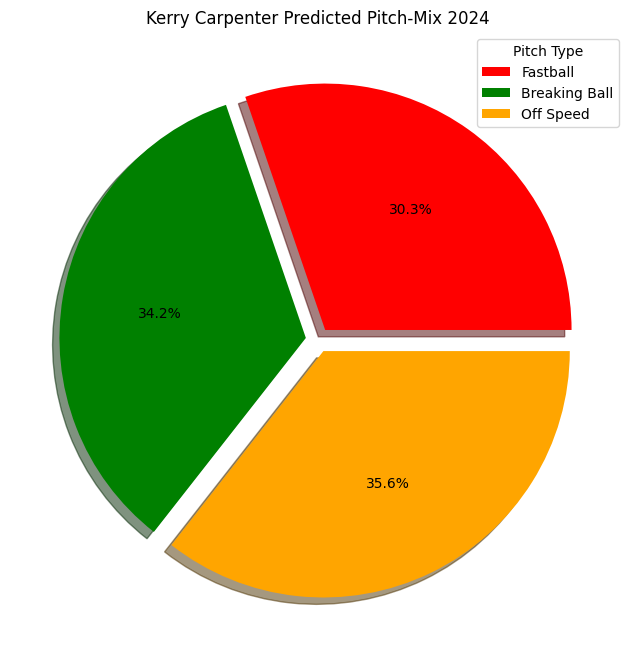

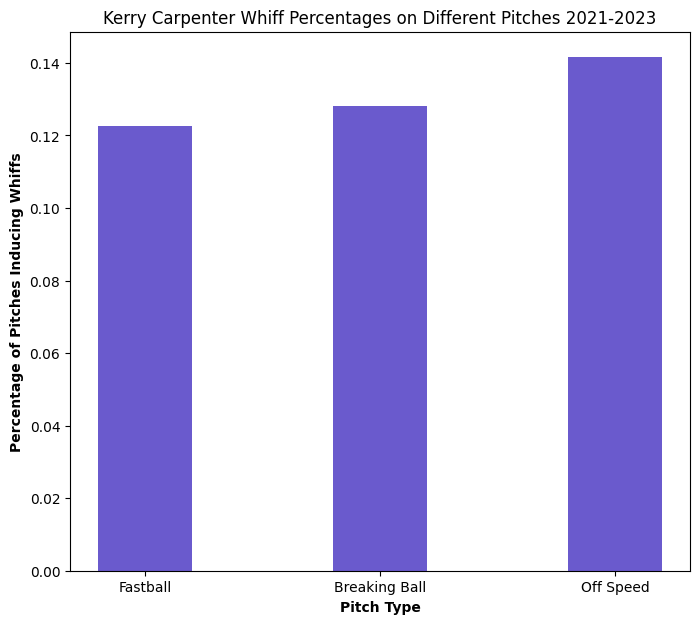

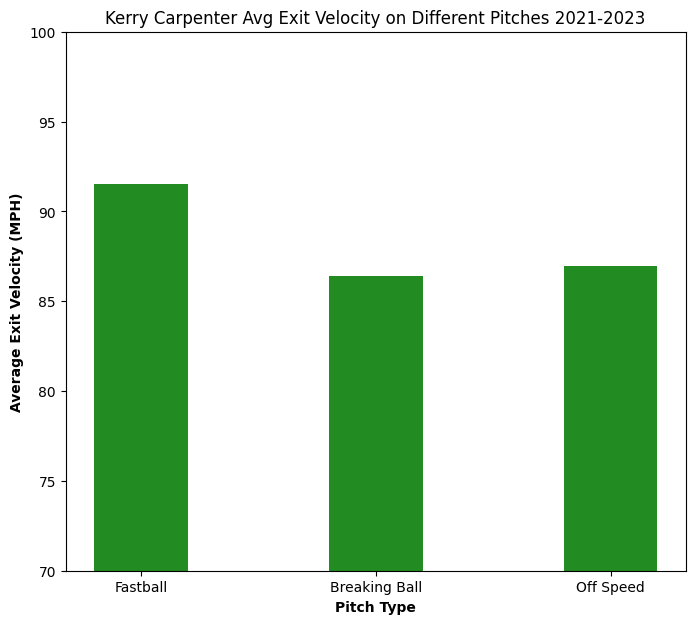

In [13]:

# Kerry Carpenter
kerry_props = predictions.loc[predictions["PLAYER_NAME"] == "Carpenter, Kerry"]

# Get the proportion values into a 1D array
kerry_props = kerry_props.iloc[:,3:].values[0]

# Plot to show the pitch mix proportions
fig, ax = plt.subplots(figsize=(10,8))
ax.pie(kerry_props, autopct=lambda pct: "{:.1f}%".format(pct), 
       explode=explode, colors=colors, textprops=dict(color="black"),
       shadow=True)
ax.legend(columns, title="Pitch Type", loc="upper right")
ax.set_title("Kerry Carpenter Predicted Pitch-Mix 2024")
plt.savefig("Kerry_Carpenter/Kerry_Carpenter_Pitch_Mix")

# Chart showing whiff percentages
kerry_features = feature_set.loc[feature_set["PLAYER_NAME"] == "Carpenter, Kerry"]
whiff_props = kerry_features[["whiff_fb", "whiff_bb", "whiff_os"]].values[0]
exit_velo = kerry_features[["avg_exit_velo_fb", "avg_exit_velo_bb", "avg_exit_velo_os"]].values[0]

# Make separate bar plot for whiff percentages
fig, ax = plt.subplots(figsize=(8,7))
plt.bar(columns, whiff_props, color="slateblue", width=0.4)
plt.xlabel("Pitch Type", fontweight="bold")
plt.ylabel("Percentage of Pitches Inducing Whiffs", fontweight="bold")
plt.title("Kerry Carpenter Whiff Percentages on Different Pitches 2021-2023")
plt.savefig("Kerry_Carpenter/Kerry_Carpenter_Whiff")

# Chart showing the different exit velocities
fig, ax = plt.subplots(figsize=(8,7))
plt.bar(columns, exit_velo, color="forestgreen", width=0.4)
plt.xlabel("Pitch Type", fontweight="bold")
plt.ylabel("Average Exit Velocity (MPH)", fontweight="bold")
plt.title("Kerry Carpenter Avg Exit Velocity on Different Pitches 2021-2023")
plt.ylim(70,100)
plt.savefig("Kerry_Carpenter/Kerry_Carpenter_Exit_Velo")


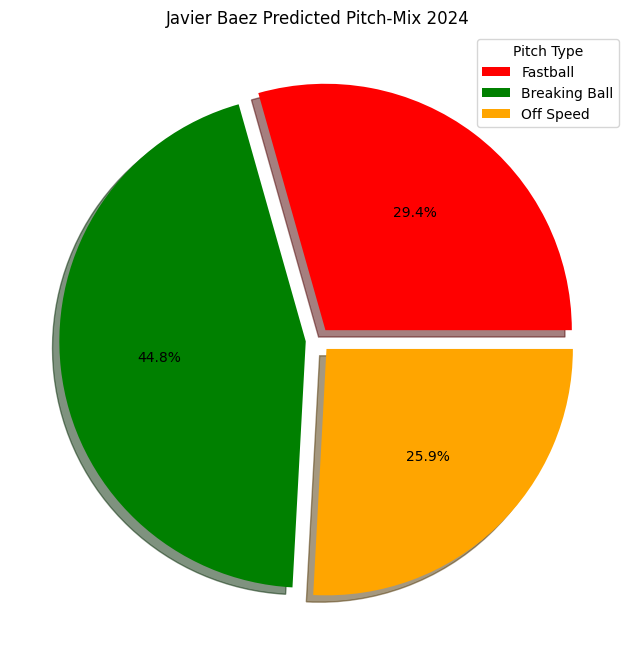

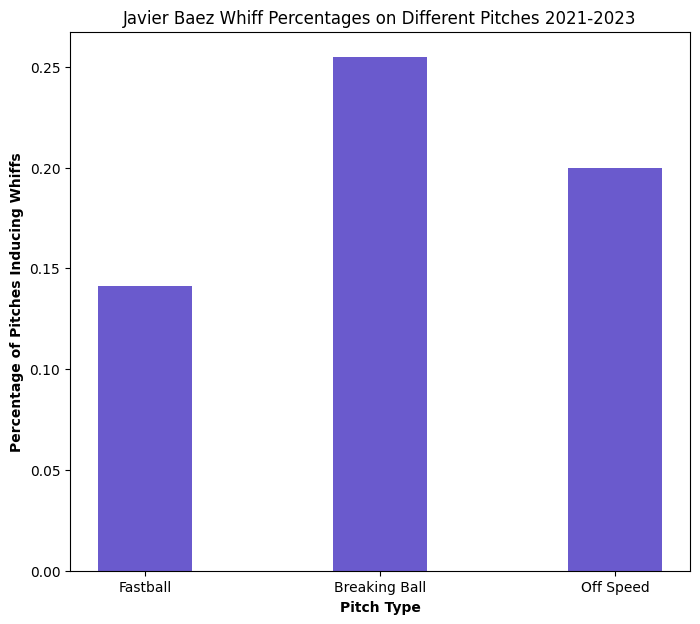

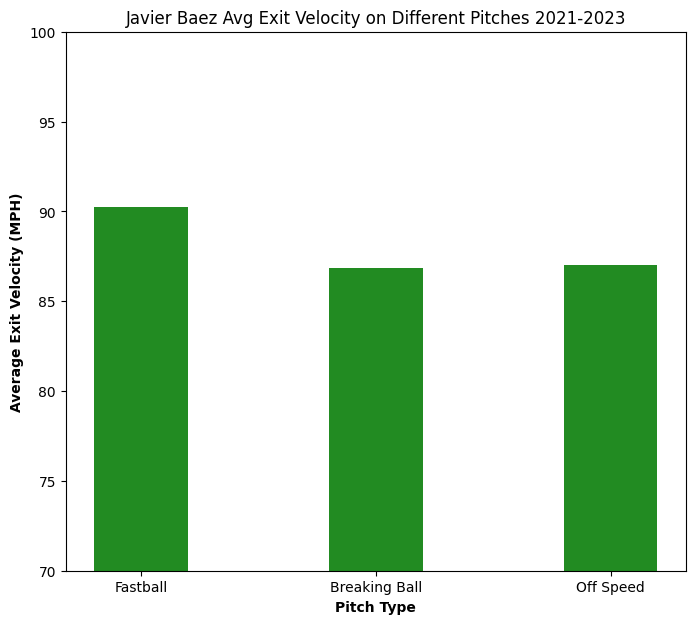

In [14]:
# Javier Baez

javy_props = predictions.loc[predictions["PLAYER_NAME"] == "Báez, Javier"]

# Get the proportion values into a 1D array
javy_props = javy_props.iloc[:,3:].values[0]

fig, ax = plt.subplots(figsize=(10,8))
ax.pie(javy_props, autopct=lambda pct: "{:.1f}%".format(pct), 
       explode=explode, colors=colors, textprops=dict(color="black"),
       shadow=True)
ax.legend(columns, title="Pitch Type", loc="upper right")
ax.set_title("Javier Baez Predicted Pitch-Mix 2024")
plt.savefig("Javier_Baez/Javier_Baez_Pitch_Mix")

# Chart showing whiff percentages
javy_features = feature_set.loc[feature_set["PLAYER_NAME"] == "Báez, Javier"]
whiff_props = javy_features[["whiff_fb", "whiff_bb", "whiff_os"]].values[0]
exit_velo = javy_features[["avg_exit_velo_fb", "avg_exit_velo_bb", "avg_exit_velo_os"]].values[0]

# Make separate bar plot for whiff percentages
fig, ax = plt.subplots(figsize=(8,7))
plt.bar(columns, whiff_props, color="slateblue", width=0.4)
plt.xlabel("Pitch Type", fontweight="bold")
plt.ylabel("Percentage of Pitches Inducing Whiffs", fontweight="bold")
plt.title("Javier Baez Whiff Percentages on Different Pitches 2021-2023")
plt.savefig("Javier_Baez/Javier_Baez_Whiff")

# Chart showing the different exit velocities
fig, ax = plt.subplots(figsize=(8,7))
plt.bar(columns, exit_velo, color="forestgreen", width=0.4)
plt.xlabel("Pitch Type", fontweight="bold")
plt.ylabel("Average Exit Velocity (MPH)", fontweight="bold")
plt.title("Javier Baez Avg Exit Velocity on Different Pitches 2021-2023")
plt.ylim(70,100)
plt.savefig("Javier_Baez/Javier_Baez_Exit_Velo")
